In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
# Split into structured target for survival analysis and features
from sksurv.util import Surv


In [8]:
df = pd.read_csv('../raw_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
# Set EmployeeNumber as the index
df.set_index("EmployeeNumber", inplace=True)
# Drop irrelevant columns
df.drop(columns=["EmployeeCount","StandardHours", "Over18"], inplace=True)
# Create boolean target
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Split into structured target for survival analysis and features
X = df.drop(columns=['Attrition', 'YearsAtCompany'])
y = Surv.from_arrays(event=df["Attrition"] == 1, time=df["YearsAtCompany"])

In [9]:
# **Create a Custom Transformer to Convert Output to DataFrame**
# Need it for GradientBoostingSurvivalAnalysis to retain feature names

from sklearn.base import BaseEstimator, TransformerMixin


class ToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, preprocessor):
        """
        Initialize the transformer with a fitted preprocessor.
        :param preprocessor: A fitted ColumnTransformer or similar preprocessor.
        """
        self.preprocessor = preprocessor
        self.feature_names = None

    def fit(self, X, y=None):
        """
        Fit the transformer (no-op since the preprocessor is already fitted).
        """
        # Extract feature names from the fitted preprocessor
        self.feature_names = self.preprocessor.get_feature_names_out()
        return self

    def transform(self, X):
        """
        Transform the input data into a DataFrame with feature names.
        :param X: Input data (NumPy array or similar).
        :return: Pandas DataFrame with feature names.
        """
        return pd.DataFrame(X, columns=self.feature_names)

In [10]:
# Define numerical and categorical features
numerical_columns = ['Age', 'DailyRate', 'MonthlyRate','DistanceFromHome', 'HourlyRate', 'JobInvolvement', 
                     'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 
                     'PerformanceRating','TotalWorkingYears', 
                     'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsInCurrentRole', 
                     'YearsSinceLastPromotion', 'YearsWithCurrManager']

categorical_columns = ['Gender', 'BusinessTravel', 'Department', 'EducationField', 'JobRole', 
                       'MaritalStatus', 'OverTime']

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    verbose_feature_names_out = False,
    remainder='passthrough'
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

In [12]:
# Define the model
model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1)

# Create the pipeline with the custom transformer
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dataframe', ToDataFrame(preprocessor=preprocessor)),  # Pass the preprocessor
    ('model', model)
])
# Fit the model
pipeline.fit(X_train, y_train)

/Users/yuliav/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'DailyRate',
                                                   'MonthlyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'Years...
                                                                            'PerformanceRating',
                                                                            'TotalWorkingYears',
                                                                            'TrainingTimesLastYear',
                                                                            'WorkLifeBalance',
                                                                            'YearsInCurrentRole',
                                                                            'YearsSinceLastPromotion',
                                                                            'YearsWithCurrManager']),
                                                                          ('cat',
                                                                           OneHotEncoder(),
                                                                           ['Gender',
                                                                            'BusinessTravel',
                                                                            'Department',
                                                                            'EducationField',
                                                                            'JobRole',
                                                                            'MaritalStatus',
                                                                            'OverTime'])],
                                                            verbose_feature_names_out=False))),
                ('model', GradientBoostingSurvivalAnalysis())])

In [13]:
# Predict risk scores (higher = more likely to leave sooner)
predicted_risk = pipeline.predict(X_test)
# Calculate concordance index
c_index = concordance_index_censored(y_test['event'], y_test['time'], predicted_risk)
print(f'Concordance Index: {c_index[0]}')

Concordance Index: 0.8998608299595142


Text(0.5, 1.0, 'Feature Importance in Employee Attrition Prediction')

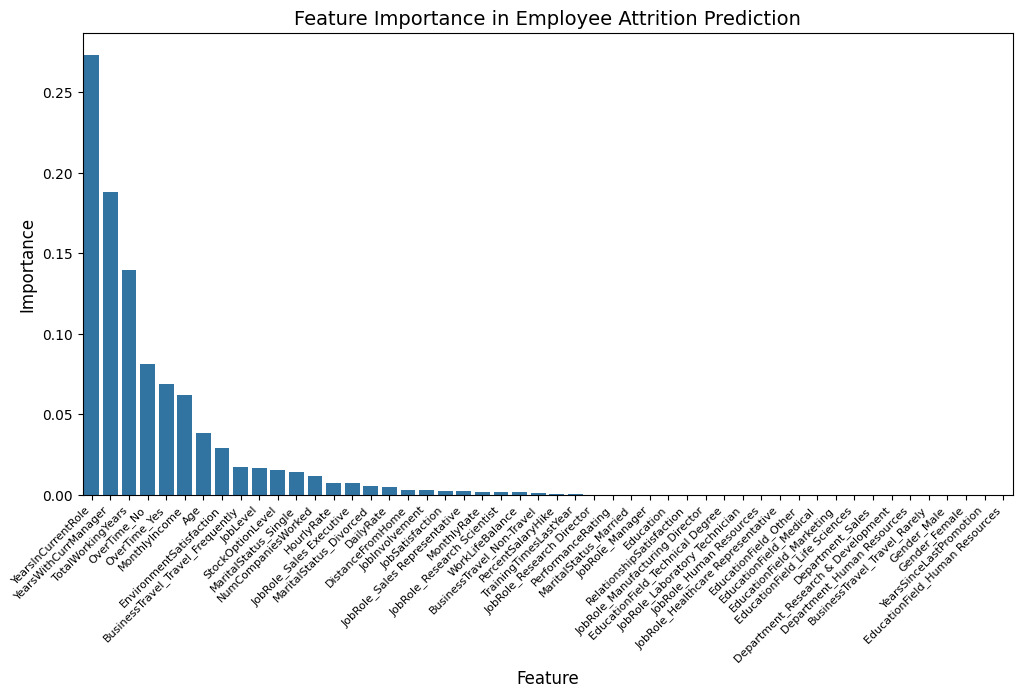

In [14]:
# 🔹 Feature Importance Interpretation 🔹
# Extract feature importances from the model
feature_importances = pipeline.named_steps['model'].feature_importances_
preprocessor = pipeline.named_steps['preprocessor']
transformed_feature_names = preprocessor.get_feature_names_out()
# Sort and plot feature importance
feature_importance_df = pd.DataFrame({'Feature': transformed_feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)

plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate labels diagonally, align right, reduce font size
plt.xlabel("Feature", fontsize=12)  # Label x-axis
plt.ylabel("Importance", fontsize=12)  # Label y-axis
plt.title("Feature Importance in Employee Attrition Prediction", fontsize=14)  # Add title

In [59]:
import shap

# Define a callable prediction function for SHAP
def predict_risk_scores(X):
    """
    Custom prediction function for the pipeline.
    X: Input data (NumPy array or Pandas DataFrame).
    Returns: Predicted risk scores (higher means more likely to experience the event).
    """
        # Convert X to a DataFrame if it's a NumPy array
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=transformed_feature_names)
        
    # Get the predicted risk scores from the model
    risk_scores = model.predict(X)
    
    return risk_scores

# Get feature names after preprocessing
transformed_feature_names = preprocessor.get_feature_names_out()

# Sample a subset of the training data for the background dataset
background_data = shap.utils.sample(X_train, 200)  # Use 100 samples for efficiency

# Preprocess the background data using the pipeline's preprocessor
background_data_transformed = preprocessor.transform(background_data)

# Convert the preprocessed background data to a DataFrame
background_data_transformed = pd.DataFrame(background_data_transformed, columns=transformed_feature_names)

In [60]:
# Use SHAP's KernelExplainer
explainer = shap.KernelExplainer(predict_risk_scores, background_data_transformed)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/294 [00:00<?, ?it/s]

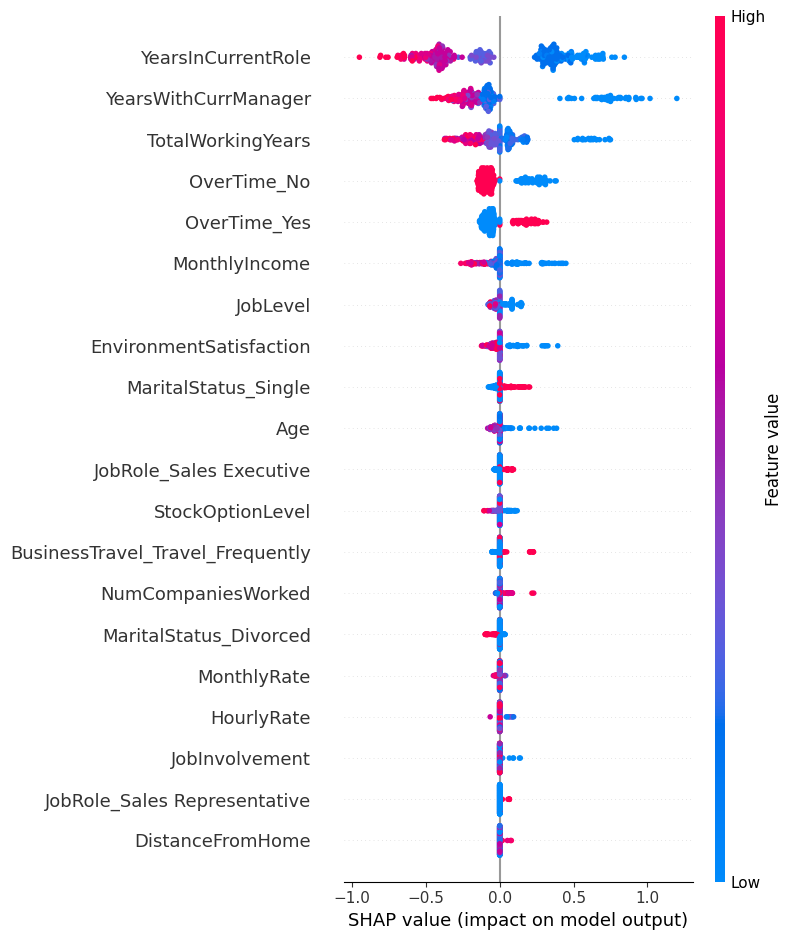

In [61]:
# Preprocess the test data (if not already preprocessed)
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Summary plot (shows direction and impact of each feature)
shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_feature_names)

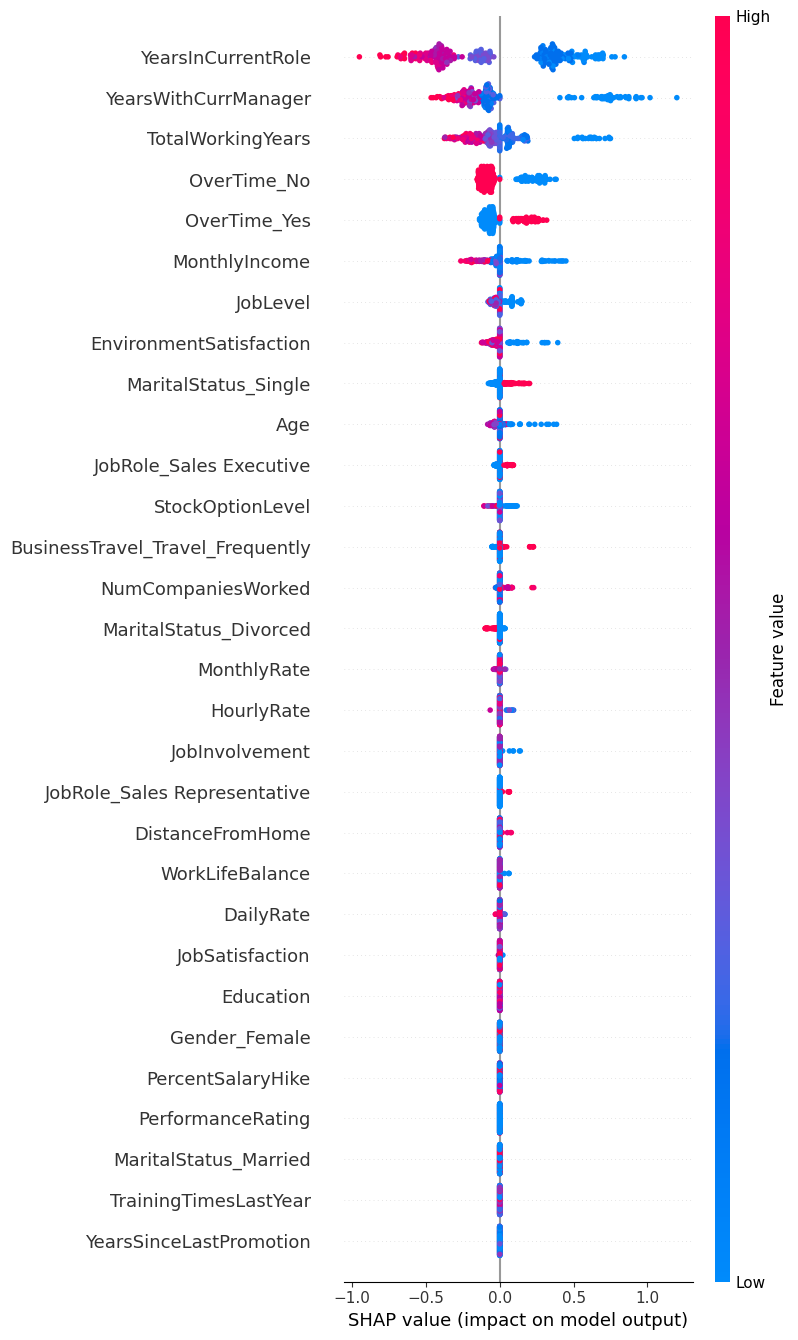

In [63]:
# Summary plot (shows direction and impact of each feature)
shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_feature_names, max_display=30)

In [ ]:
impact_features = ['JobRole',  'JobLevel','JobInvolvement','OverTime', 'MonthlyIncome','EnvironmentSatisfaction', 'BusinessTravel',]

In [ ]:
numerical_columns = ['Age', 'DailyRate', 'MonthlyRate','DistanceFromHome', 'HourlyRate', 'JobInvolvement', 
                     'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 
                     'PerformanceRating','TotalWorkingYears', 
                     'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsInCurrentRole', 
                     'YearsSinceLastPromotion', 'YearsWithCurrManager']

categorical_columns = ['Gender', 'BusinessTravel', 'Department', 'EducationField', 'JobRole', 
                       'MaritalStatus', 'OverTime']


In [32]:
from sksurv.functions import StepFunction
import plotly.express as px

def plot_survival_curves(X,pipeline, num_samples=10):
    """Plots survival curves for n employees at most risk"""

    # Filter df to include only employees who haven't quit (Attrition == 0)
    X_active = X[X['Attrition'] == 0]
    X = X.drop(columns=['Attrition'])
    # Add the predicted risk scores to the DataFrame
    X_active['PredictedRisk'] = pipeline.predict(X_active)
    
    # Sort by predicted risk (highest risk first)
    X_active_sorted = X_active.sort_values(by='PredictedRisk', ascending=False)
    
    # Display the top 10 employees at highest risk
    top_n_high_risk = X_active_sorted.head(num_samples)
    print(top_n_high_risk[['PredictedRisk']])
    
    # Preprocess the top high-risk employees' data
    top_n_high_risk_proc = pipeline.named_steps['preprocessor'].transform(top_n_high_risk.drop(columns=['PredictedRisk']))
    top_n_high_risk_proc = pipeline.named_steps['to_dataframe'].transform(top_n_high_risk_proc)
    survival_funcs = pipeline.named_steps['model'].predict_survival_function(top_n_high_risk_proc)
    
    # Create a DataFrame to store survival probabilities for the top n high-risk employees
    survival_data = []
    # Extract time points and survival probabilities from the survival functions (StepFunction)
    for i, employee_id in enumerate(top_n_high_risk.index):
        step_function = survival_funcs[i]  # Get the StepFunction for the current employee
        time_points = step_function.x  # Time points
        survival_prob = step_function.y  # Survival probabilities
    
        # Add the survival curve to the DataFrame
        for time, prob in zip(time_points, survival_prob):
            survival_data.append({
                'EmployeeNumber': employee_id,
                'Time': time,
                'SurvivalProbability': prob
            })

    # Convert the survival data to a DataFrame
    survival_df = pd.DataFrame(survival_data)

    # Create an interactive survival curve plot using plotly
    fig = px.line(
        survival_df,
        x='Time',
        y='SurvivalProbability',
        color='EmployeeNumber',
        labels={'Time': 'Time (Years)', 'SurvivalProbability': 'Survival Probability'},
        title='Survival Curves for Top 10 High-Risk Employees',
        hover_name='EmployeeNumber'  # Show EmployeeNumber on hover
    )

    # Customize the plot
    fig.update_traces(mode='lines+markers', marker=dict(size=5))
    fig.update_layout(
        xaxis_title='Time (Years)',
        yaxis_title='Survival Probability',
        legend_title='Employee Number',
        hovermode='x unified'
    )

    # Show the plot
    fig.show()



In [38]:
df = pd.read_csv('../raw_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
# Set EmployeeNumber as the index
df.set_index("EmployeeNumber", inplace=True)
# Drop irrelevant columns
df.drop(columns=["EmployeeCount","StandardHours", "Over18"], inplace=True)
# Create boolean target
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Split into structured target for survival analysis and features
X = df.drop(columns=['YearsAtCompany'])



In [ ]:
# Plot survival curves
plot_survival_curves(X,pipeline)

In [39]:
num_samples = 10
# Filter df to include only employees who haven't quit (Attrition == 0)
X_active = X[X['Attrition'] == 0]
X = X.drop(columns=['Attrition'])
# Add the predicted risk scores to the DataFrame
X_active['PredictedRisk'] = pipeline.predict(X_active)

# Sort by predicted risk (highest risk first)
X_active_sorted = X_active.sort_values(by='PredictedRisk', ascending=False)

# Display the top 10 employees at highest risk
top_n_high_risk = X_active_sorted.head(num_samples)
print(top_n_high_risk[['PredictedRisk']])

                PredictedRisk
EmployeeNumber               
556                  3.104934
1193                 3.023397
1242                 2.887646
1839                 2.795685
30                   2.793369
1012                 2.701631
201                  2.692527
411                  2.692527
1368                 2.600789
1551                 2.504149


In [40]:
top_n_high_risk

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PredictedRisk
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
556,38,0,Travel_Frequently,1490,Research & Development,2,2,Life Sciences,4,Male,...,4,3,1,1,3,3,0,0,0,3.104934
1193,19,0,Travel_Rarely,645,Research & Development,9,2,Life Sciences,3,Male,...,4,3,0,1,4,3,1,0,0,3.023397
1242,42,0,Travel_Frequently,458,Research & Development,26,5,Medical,1,Female,...,3,3,0,20,6,3,0,0,0,2.887646
1839,18,0,Non-Travel,1431,Research & Development,14,3,Medical,2,Female,...,3,3,0,0,4,1,0,0,0,2.795685
30,21,0,Travel_Rarely,391,Research & Development,15,2,Life Sciences,3,Male,...,3,4,0,0,6,3,0,0,0,2.793369
1012,18,0,Non-Travel,287,Research & Development,5,2,Life Sciences,2,Male,...,3,4,0,0,2,3,0,0,0,2.701631
201,19,0,Travel_Rarely,1181,Research & Development,3,1,Medical,2,Female,...,3,4,0,1,3,3,0,0,0,2.692527
411,18,0,Travel_Rarely,812,Sales,10,3,Medical,4,Female,...,3,1,0,0,2,3,0,0,0,2.692527
1368,18,0,Non-Travel,1124,Research & Development,1,3,Life Sciences,4,Female,...,3,3,0,0,5,4,0,0,0,2.600789


In [43]:
# Preprocess the top high-risk employees' data
top_n_high_risk_proc = pipeline.named_steps['preprocessor'].transform(top_n_high_risk.drop(columns=['PredictedRisk']))
top_n_high_risk_proc = pipeline.named_steps['to_dataframe'].transform(top_n_high_risk_proc)
survival_funcs = pipeline.named_steps['model'].predict_survival_function(top_n_high_risk_proc)
    

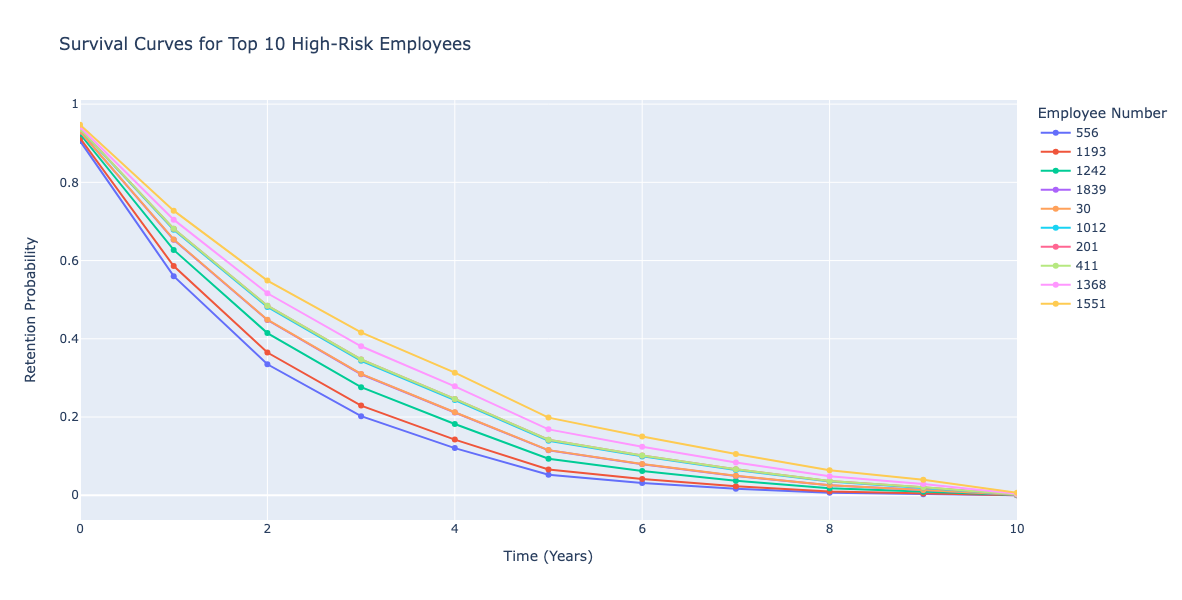

In [52]:
# Create a DataFrame to store survival probabilities for the top n high-risk employees
survival_data = []
# Extract time points and survival probabilities from the survival functions (StepFunction)
for i, employee_id in enumerate(top_n_high_risk.index):
    step_function = survival_funcs[i]  # Get the StepFunction for the current employee
    time_points = step_function.x  # Time points
    survival_prob = step_function.y  # Survival probabilities

    # Add the survival curve to the DataFrame
    for time, prob in zip(time_points, survival_prob):
        survival_data.append({
            'EmployeeNumber': employee_id,
            'Time': time,
            'SurvivalProbability': prob
        })

# Convert the survival data to a DataFrame
survival_df = pd.DataFrame(survival_data)

# Create an interactive survival curve plot using plotly.graph_objects
fig = go.Figure()


# Create an interactive survival curve plot using plotly
fig = px.line(
    survival_df,
    x='Time',
    y='SurvivalProbability',
    color='EmployeeNumber',
    labels={'Time': 'Time (Years)', 'SurvivalProbability': 'Retention Probability'},
    title= f'Survival Curves for Top {num_samples} High-Risk Employees'
)

# Customize the plot
fig.update_traces(mode='lines+markers')
fig.update_layout(
    xaxis_title='Time (Years)',
    yaxis_title='Retention Probability',
    legend_title='Employee Number',
    xaxis_range=[0, 10],  # Set x-axis range to 0-10 years
    height=600,
    width=900 
)

# Show the plot
fig.show()


  0%|          | 0/10 [00:00<?, ?it/s]

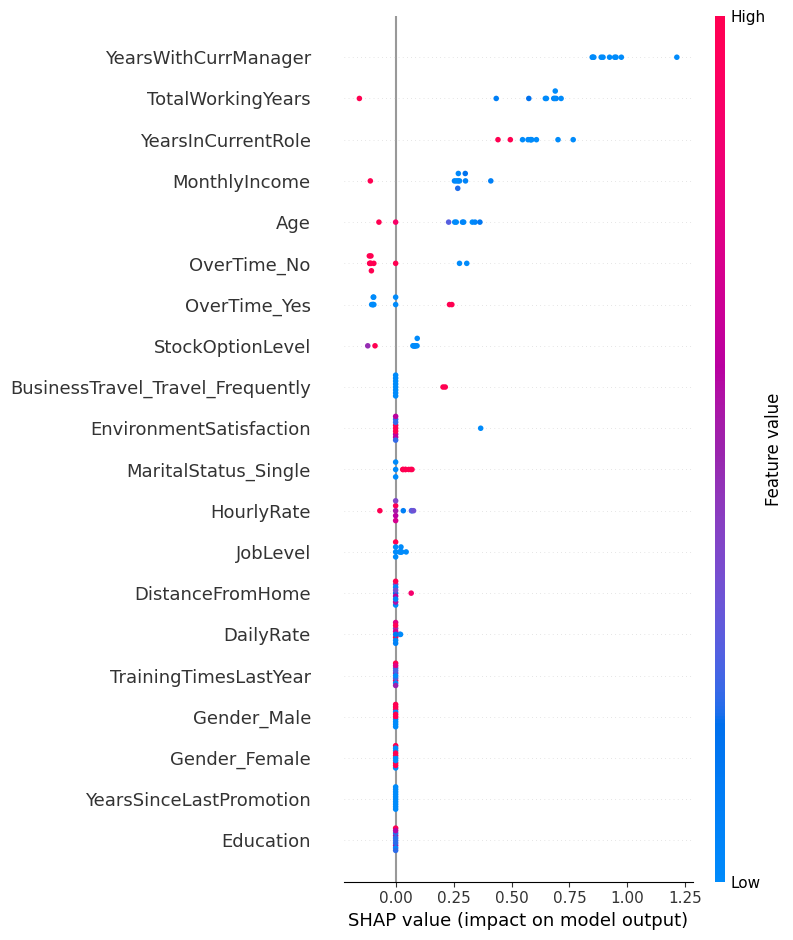

In [54]:
# Get feature names after preprocessing
transformed_feature_names = preprocessor.get_feature_names_out()

# Use SHAP's KernelExplainer
# explainer = shap.KernelExplainer(predict_risk_scores, X_test)

# Get SHAP values for the top_n_high_risk_proc
shap_values = explainer.shap_values(top_n_high_risk_proc)

# Summary plot (shows direction and impact of each feature)
shap.summary_plot(shap_values, top_n_high_risk_proc, feature_names=transformed_feature_names)

In [53]:
top_n_high_risk_proc

,Age,DailyRate,MonthlyRate,DistanceFromHome,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes,Education,EnvironmentSatisfaction,JobSatisfaction,RelationshipSatisfaction,StockOptionLevel
0,0.138005,1.698504,-0.306164,-0.894093,-1.183791,0.389015,-0.945659,-1.009444,-0.669557,2.113796,...,0.0,1.0,0.0,0.0,1.0,2.0,4.0,4.0,3.0,1.0
1,-1.946908,-0.405780,-0.998439,-0.029817,-0.594838,0.389015,-0.945659,-0.825540,-0.669557,2.659651,...,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,3.0,0.0
2,0.576934,-0.871461,1.261767,2.069138,-0.300361,0.389015,0.884950,1.476287,0.158413,0.476231,...,0.0,1.0,0.0,0.0,1.0,5.0,1.0,1.0,3.0,0.0
3,-2.056640,1.551578,-0.879739,0.587523,-1.625505,0.389015,-0.945659,-1.050119,-0.669557,0.203303,...,0.0,0.0,1.0,1.0,0.0,3.0,2.0,3.0,3.0,0.0
4,-1.727443,-1.038310,0.700539,0.710991,1.466498,0.389015,-0.945659,-1.111132,-0.669557,-0.342552,...,0.0,0.0,1.0,1.0,0.0,2.0,3.0,4.0,4.0,0.0
5,-2.056640,-1.297299,-0.111558,-0.523689,0.337671,0.389015,-0.945659,-1.150292,-0.669557,-0.069624,...,0.0,0.0,1.0,1.0,0.0,2.0,2.0,4.0,4.0,0.0
6,-1.946908,0.929009,0.254503,-0.770625,0.632148,0.389015,-0.945659,-1.056826,-0.669557,-0.342552,...,0.0,0.0,1.0,1.0,0.0,1.0,2.0,2.0,4.0,0.0
7,-2.056640,0.010097,-0.640376,0.093651,0.141354,-1.005745,-0.945659,-1.118055,-0.669557,-0.888407,...,0.0,0.0,1.0,1.0,0.0,3.0,4.0,3.0,1.0,0.0
8,-2.056640,0.787063,0.703906,-1.017561,1.515577,0.389015,-0.945659,-1.029132,-0.669557,-0.069624,...,0.0,0.0,1.0,1.0,0.0,3.0,4.0,4.0,3.0,0.0
9,-1.398247,-1.140411,-0.596600,1.451798,-0.447599,-1.005745,-0.945659,-0.880927,-1.083542,-0.342552,...,1.0,0.0,0.0,1.0,0.0,2.0,3.0,1.0,2.0,3.0
